In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

In [2]:
# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

In [4]:
# K-fold cross-validation
n_folds = 2
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
histories = []

for train_index, val_index in kfold.split(train_images, train_labels):
    x_train_fold, x_val_fold = train_images[train_index], train_images[val_index]
    y_train_fold, y_val_fold = train_labels_categorical[train_index], train_labels_categorical[val_index]

    # Build the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
    datagen.fit(x_train_fold)

    # Train the model
    batch_size = 64
    epochs = 50
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                        steps_per_epoch=x_train_fold.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
    histories.append(history)


Epoch 1/50
390/390 [==============================] - 30s 52ms/step - loss: 2.8080 - accuracy: 0.1977 - val_loss: 2.8102 - val_accuracy: 0.1338
Epoch 2/50
390/390 [==============================] - 18s 46ms/step - loss: 2.3146 - accuracy: 0.2709 - val_loss: 1.7360 - val_accuracy: 0.3594
Epoch 3/50
390/390 [==============================] - 20s 50ms/step - loss: 2.0924 - accuracy: 0.3071 - val_loss: 1.7145 - val_accuracy: 0.3652
Epoch 4/50
390/390 [==============================] - 22s 55ms/step - loss: 1.9488 - accuracy: 0.3338 - val_loss: 1.6919 - val_accuracy: 0.3772
Epoch 5/50
390/390 [==============================] - 25s 63ms/step - loss: 1.8356 - accuracy: 0.3648 - val_loss: 1.5909 - val_accuracy: 0.4193
Epoch 6/50
390/390 [==============================] - 18s 46ms/step - loss: 1.7417 - accuracy: 0.3858 - val_loss: 1.6038 - val_accuracy: 0.4180
Epoch 7/50
390/390 [==============================] - 19s 49ms/step - loss: 1.6877 - accuracy: 0.4034 - val_loss: 1.6594 - val_accuracy:

In [5]:
# Average the histories
average_history = {}
for key in histories[0].history.keys():
    average_history[key] = np.mean([h.history[key] for h in histories], axis=0)

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels_categorical)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.8696 - accuracy: 0.7014
Test accuracy: 0.7013999819755554


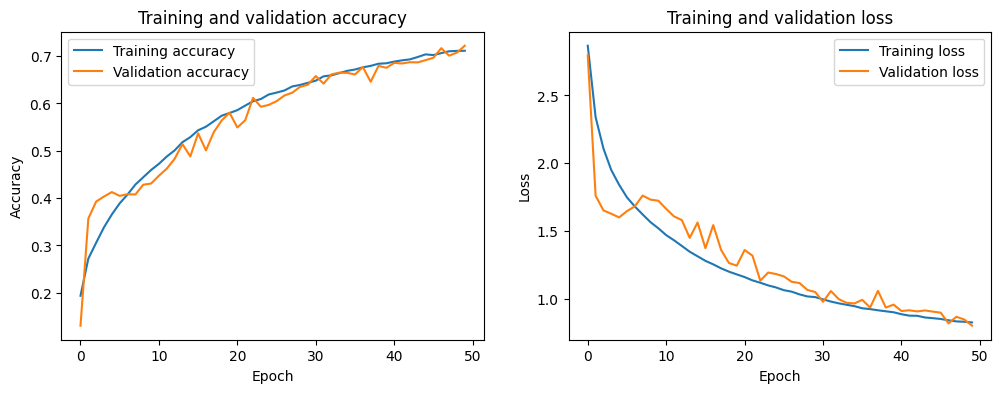

In [7]:
# Plot the average training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training accuracy')
    plt.plot(history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and validation accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and validation loss')
    plt.show()

plot_history(average_history)

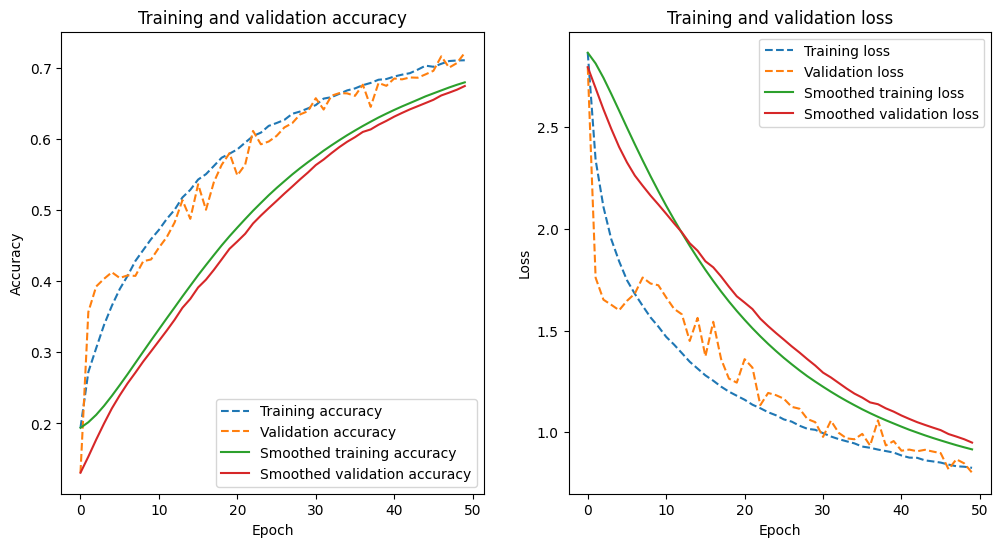

In [8]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training accuracy', linestyle='--')
    plt.plot(history['val_accuracy'], label='Validation accuracy', linestyle='--')
    plt.plot(smooth_curve(history['accuracy']), label='Smoothed training accuracy')
    plt.plot(smooth_curve(history['val_accuracy']), label='Smoothed validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and validation accuracy')
    
    # Training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training loss', linestyle='--')
    plt.plot(history['val_loss'], label='Validation loss', linestyle='--')
    plt.plot(smooth_curve(history['loss']), label='Smoothed training loss')
    plt.plot(smooth_curve(history['val_loss']), label='Smoothed validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and validation loss')
    
    plt.show()

plot_history(average_history)


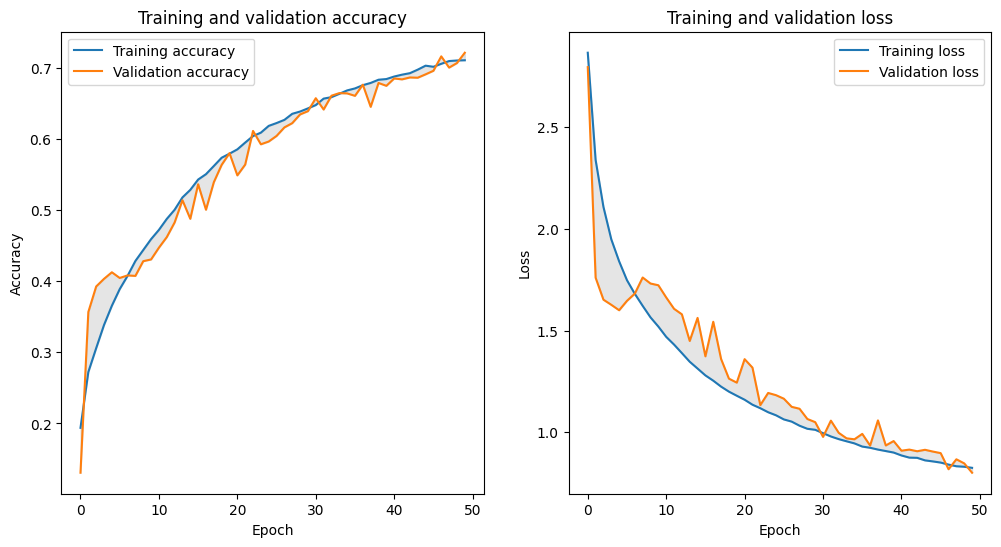

In [9]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training accuracy')
    plt.plot(history['val_accuracy'], label='Validation accuracy')
    plt.fill_between(range(len(history['accuracy'])), history['accuracy'], history['val_accuracy'], color='gray', alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and validation accuracy')
    
    # Training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.fill_between(range(len(history['loss'])), history['loss'], history['val_loss'], color='gray', alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and validation loss')
    
    plt.show()

plot_history(average_history)
